In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Convert MNIST Image Files into Tensor of 4-Dimensions (# of images, Height, Width, Color chanel)
transform = transforms.ToTensor()

In [3]:
# Train Data
train_data = datasets.MNIST(root = '/cnn_data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root = '/cnn_data', train=False, download=True, transform=transform)



100%|██████████| 9.91M/9.91M [00:00<00:00, 56.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.74MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.9MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.29MB/s]


In [4]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: /cnn_data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [5]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: /cnn_data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [6]:
# Create a small batch size for images let's say 10
train_loader = DataLoader(train_data, batch_size = 10, shuffle=True)
test_loader = DataLoader(test_data, batch_size = 10, shuffle=False)

In [7]:
# Define CNN model
conv1 = nn.Conv2d(1, 6, 3, 1)
conv2 = nn.Conv2d(6, 16, 3, 1)
conv3 = nn.Conv2d(6, 16, 3, 1)

In [8]:
# Grab 1 MNIST record
for i, (X_Train, y_train) in enumerate(train_data):
     break

In [9]:
X_Train.shape

torch.Size([1, 28, 28])

In [10]:
x = X_Train.view(1,1,28,28)

In [11]:
# Perform our first convolution
x = F.relu(conv1(x))

In [12]:
# 1 single image, 6 filters we ask for
x.shape

torch.Size([1, 6, 26, 26])

In [13]:
x = F.max_pool2d(x,2,2) # kernel of 2 and stride of 2

In [14]:
x.shape # 26 / 2 = 13

torch.Size([1, 6, 13, 13])

In [15]:
# Do our second convolutional layer
x = F.relu(conv2(x))

In [16]:
x.shape # Again, we didn't set padding so we lose 2 pixles around the outside of the image

torch.Size([1, 16, 11, 11])

In [17]:
x = F.max_pool2d(x, 2, 2)  # 11 / 2 and round down

In [18]:
x.shape

torch.Size([1, 16, 5, 5])

In [19]:
# Model class

class ConvolutionalNetwork(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 8, 3, 1)
        self.conv2 = nn.Conv2d(8, 16, 3 , 1)

        # Fully connected Layer
        self.fc1 = nn.Linear(5*5*16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2) # 2x2 kernel and stride 2

        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2) # 2x2 kernel and stride 2

        # Review to flatten it out
        X = X.view(-1, 16*5*5)

        # Fully connected layer
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)

In [20]:
# Create an Instance of our model
torch.manual_seed(42)

model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [ ]:
# Loss Function Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # smaller lr -> longer it gona take to train


In [ ]:
import time
start_time= time.time()

# Create Variables to Tracks Things
epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

# For loop of Epochs
for i in range(epochs):
    train_corr = 0
    test_corr = 0

    # Train
    for b, (X_train, y_train) in enumerate(train_loader):
        b+=1 # start our batch at 1
        y_pred = model(X_train) # Get predicted values from the training set. Not flattened
        loss = criterion(y_pred, y_train) # How off are we? Compare predictions to correct answers

        predicted = torch.max(y_pred.data, 1)[1] # add up the number of correct predictions. Indexed of first
        batch_corr = (predicted == y_train).sum() # How many we got correct from this batch
        train_corr += batch_corr

        # Update our parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print out some results
        if b%600 == 0:
            print(f'Epoch : {i} Batch: {b} Loss: {loss.item()}')
    train_losses.append(loss)
    train_correct.append(train_corr)

    # Test
    with torch.no_grad(): # No gradient -> don't update weight and bias
        for b, (X_test, y_test) in enumerate(test_loader):
            y_val = model(X_test)
            predicted = torch.max(y_val.data, 1)[1]
            test_corr += (predicted == y_test).sum()

    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(test_corr)

current_time = time.time()
total = current_time - start_time
print(f'Training took: {total/60} minutes')

Epoch : 0 Batch: 600 Loss: 0.5875072479248047
Epoch : 0 Batch: 1200 Loss: 0.04223901778459549
Epoch : 0 Batch: 1800 Loss: 0.022206589579582214
Epoch : 0 Batch: 2400 Loss: 0.6292003393173218
Epoch : 0 Batch: 3000 Loss: 0.004994042217731476
Epoch : 0 Batch: 3600 Loss: 0.40914154052734375
Epoch : 0 Batch: 4200 Loss: 0.005965267773717642
Epoch : 0 Batch: 4800 Loss: 0.22413718700408936
Epoch : 0 Batch: 5400 Loss: 0.06823741644620895
Epoch : 0 Batch: 6000 Loss: 0.0007726304465904832
Epoch : 1 Batch: 600 Loss: 0.004085364751517773
Epoch : 1 Batch: 1200 Loss: 0.16798432171344757
Epoch : 1 Batch: 1800 Loss: 0.0010387167567387223
Epoch : 1 Batch: 2400 Loss: 0.003768857568502426
Epoch : 1 Batch: 3000 Loss: 0.0010630697943270206
Epoch : 1 Batch: 3600 Loss: 0.0009167814860120416
Epoch : 1 Batch: 4200 Loss: 0.00526504497975111
Epoch : 1 Batch: 4800 Loss: 0.014944000169634819
Epoch : 1 Batch: 5400 Loss: 0.0006506106583401561
Epoch : 1 Batch: 6000 Loss: 0.0003495833952911198
Epoch : 2 Batch: 600 Loss:

Text(0.5, 1.0, 'Loss at Epoch')

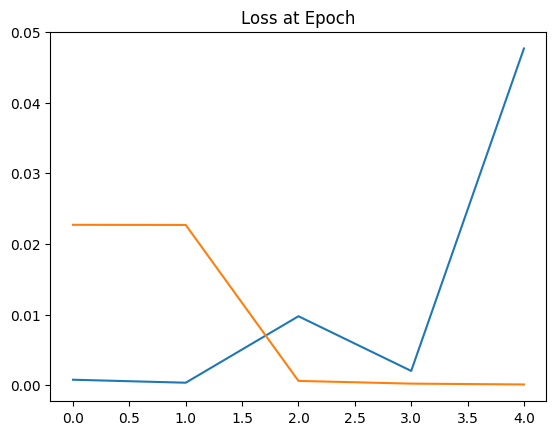

In [ ]:
train_losses = [tl.item() for tl in train_losses]

plt.plot(train_losses, label="Training Loss")
plt.plot(test_losses, label = "Validation Loss")
plt.title("Loss at Epoch")

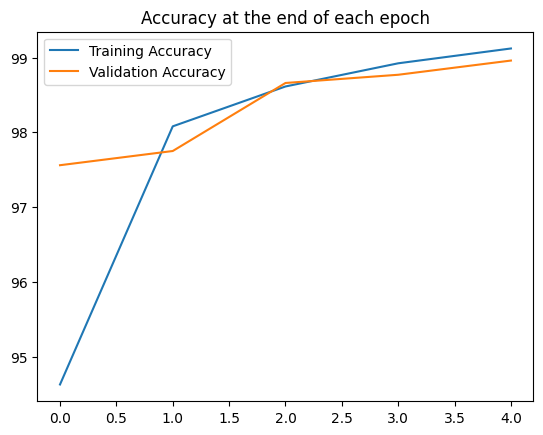

In [ ]:
plt.plot([t/600 for t in train_correct], label="Training Accuracy")
plt.plot([t/100 for t in test_correct], label="Validation Accuracy")
plt.title('Accuracy at the end of each epoch')
plt.legend()

In [ ]:
test_load_everything = DataLoader(test_data, batch_size=10000, shuffle=False)

In [ ]:
with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_everything:
        y_val = model(X_test)
        predicted = torch.max(y_val, 1)[1]
        correct += (predicted == y_test).sum()

In [ ]:
correct.item()

9896

In [ ]:
correct.item()/len(test_data)*100

98.96000000000001

In [ ]:
test_data[4143] # Tensor with an image

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [ ]:
# Grab just the data
test_data[4143][0]

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

In [ ]:
# Reshape
test_data[4143][0].reshape(28,28)

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000

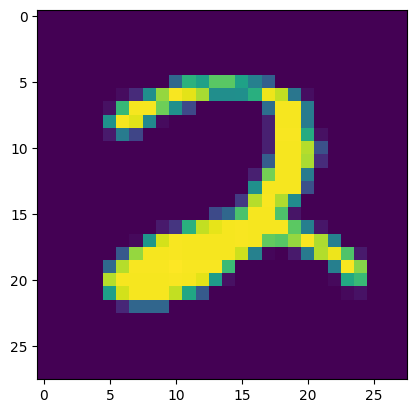

In [ ]:
# Show the image
plt.imshow(test_data[888][0].reshape(28,28))

In [ ]:
# Pass the image through model

with torch.no_grad():
    new_prediction = model(test_data[888][0].reshape(1,1,28,28)) # Batch size of 1, 1 color chanel , 28x28 image

In [ ]:
new_prediction

tensor([[-2.1586e+01, -1.9597e+01, -4.7684e-07, -1.7235e+01, -2.3400e+01,
         -2.4912e+01, -2.2469e+01, -1.4514e+01, -1.7115e+01, -2.2182e+01]])

In [ ]:
new_prediction.argmax()

tensor(2)

In [ ]:
torch.save(model.state_dict(), 'guide_mnist_model.pt')

In [ ]:
new_model = ConvolutionalNetwork()
new_model.load_state_dict(torch.load('guide_mnist_model.pt'))

<All keys matched successfully>

In [ ]:
new_model.eval()

ConvolutionalNetwork(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)